## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time:
* Instructor name: Morgan Jones
* Blog post URL: 


# Business Problem



Tanzania has water pumps installed throughout the country in order to make pottable water accessible to it's residents. Maintaining these water pumps can prove to be a challenge, since many are in remote areas that are difficult to monitor. 

The goal of this project is to build a model that can predict which water pumps are in need of repair in order to efficiently dispatch technicians to the sites most in need and provide as many people as possible with clean water.

## The Data



A dataset of Tanzania water pumps is maintained by Taarifa in a waterpoints dashboard by aggregating data from the Tanzania Ministry of Water. This data set keeps track of information regarding the location of the water pump, information about the pump (contruction year, extraction type, etc.), the people involved in the pump (installers, management, population), as well as the information regarding the source of water feeding the pump.

Additionally, the training test set provided has another test set containing the id nubmer of every pump and wheter it is functional, functional but in need of repair, or non-functional. This will allow us to train and validate our model.

Prior to cleaning, there are 59,400 water pumps in the training data set. 

# Setup

### Import relevant packages

In [1]:
import sqlite3 
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load and Clean Data

## Training values set

### Preview Data

In [2]:
training_values = pd.read_csv('data/Training_set_values.csv')
print(f'number of rows: {len(training_values)}')
training_values.head()

number of rows: 59400


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Investigate Missing Data

In [3]:
training_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Clean data

Investigate funder, installer, subvillage, public_meeting, scheme management, scheme_name, permit

- funder:
    - 3635 missing values (6.1%)
    - Not Known, Unknown,  categories
    - 0 category (same as none?)
- installer: 
    - 3655 missing values (6.1%)
    - uknown, Unknown, Not known categories
- subvillage:
    - 371 missing values (0.6%)
    - relatively few missing values
    - 19287 unique values - too many to consolidate inot meaningful categories
        - enough other location based categories
        - drop column
- public_meeting:
    - 3334 missing values (5.6%)
    - binary true/false
    - drop missing rows - want to keep it binary
- scheme management:
    - 3877 missing values (6.5%)
    - will likeley create an "unknown" column
    - one occurance of None - remove (unable to have an example in both test and training sets)
- scheme name:
    - 28166 missing values (47.4%)
    - too much missing data - drop this 
- permit:
    - 3056 missing values (5.1%)
    - binary true/false
    - drop missing rows - want to keep it binary
    
After cleaning, 53,277 data points (89% of original set)

### permit, and public_meeting columns:
- remove NaN values

In [4]:
training_values = training_values.dropna(axis=0, subset=['permit', 'public_meeting'])

### Drop unnecessary columns:
columns with majority unique values or data that is not relevant or redundant
- scheme_name, wpt_name, date_recorded, subvillage, ward

In [5]:
drop_cols = ['scheme_name', 'wpt_name', 'date_recorded', 'subvillage', 'ward']
training_values = training_values.drop(columns=drop_cols, axis=1)

### Manage "Unknown" and "Other" Categories
- Remove NaN values or convert to "unknown". 
- Combine any "not known" variations into one "unknown" column
- Combine categories with low value counts into a single "other" column

In [6]:
## clean up permit, and public_meeting columns
training_values = training_values.dropna(axis=0, subset=['permit', 'public_meeting'])

In [7]:
## clean up funder column
# combine Not Known, Unknown, and Nan categories into one 'Unknown'
training_values['funder'] = training_values['funder'].fillna('Unknown')
training_values['funder'] = training_values['funder'].map(lambda x: 'Unknown' if 'Not Known' in x else x)

# create an "other" column for all funders with less than 10 wells
#     Note: 156 was chosen as it combined sufficient small categories without making the "other" column the overwhelming majority
small_funders = []
for key, value in training_values['funder'].value_counts().to_dict().items():
    if value < 16:
        small_funders.append(key)
        
training_values['funder'] = training_values['funder'].map(lambda x: 'Other' if x in small_funders else x)

In [8]:
## clean up installer column
# combine uknown, Unknown, Not known, and Nan categories into one 'Unknown'
training_values['installer'] = training_values['installer'].fillna('Unknown')
training_values['installer'] = training_values['installer'].map(lambda x: 'Unknown' if 'Not known' in x else x)
training_values['installer'] = training_values['installer'].map(lambda x: 'Unknown' if 'unknown' in x else x)

# create an "other" column for all installers with less than 15 wells
#     Note: 15 was chosen as it combined sufficient small categories without making the "other" column the overwhelming majority
small_installers = []
for key, value in training_values['installer'].value_counts().to_dict().items():
    if value < 15:
        small_installers.append(key)
        
training_values['installer'] = training_values['installer'].map(lambda x: 'Other' if x in small_installers else x)

In [9]:
## clean up scheme_management column
# convert Nan values into one 'Unknown'
training_values['scheme_management'] = training_values['scheme_management'].fillna('Unknown')

### Remove categories with only 1 or 1 occurances

A few columns have categories with very few examples, not enough to be reliably split between the training and test data set, so those categories will be removed

In [10]:
# Scheme management: remove one row with "None"
training_values = training_values[training_values['scheme_management'] != 'None']

In [11]:
# Extratio types: remove one row with "other - mkulima/shinyanga"
training_values = training_values[training_values['extraction_type'] != 'other - mkulima/shinyanga']

In [12]:
# lga: remove one row with "Nyamagana"
training_values = training_values[training_values['lga'] != 'Nyamagana']

### Investigate value counts of final columns
Visually inspect the number of categories in each column to confirm that no column will create a large number of columns
- any categorical columns should have a "managable" number of columns
- any numberical columns do not need to have low value counts, as they will not be encoded

In [13]:
for col in list(training_values.columns):
    print(f'{col}: {len(training_values[col].value_counts())}')
# not dummy variables
# id, gps_height, population, construction_year

id: 53277
amount_tsh: 91
funder: 302
gps_height: 2426
installer: 304
longitude: 51777
latitude: 51779
num_private: 61
basin: 9
region: 21
region_code: 27
district_code: 20
lga: 121
population: 1006
public_meeting: 2
recorded_by: 1
scheme_management: 12
permit: 2
construction_year: 55
extraction_type: 17
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6


## Training Set Labels

Load the training set lables and restrict to only contain ids that are included in the cleaned training values dataset

In [14]:
# load data
training_labels = pd.read_csv('data/Training_set_labels.csv')

# investigate values
training_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [15]:
# create a mask for ids present in the filtered training values set
mask = training_labels['id'].isin(list(training_values.id))

# apply the mask
training_labels = training_labels[mask]
print(len(training_values))

53277


# Full Data Set Visualizations

Initial visualizations to get a look into the data set

### View the number of wells constructed per year

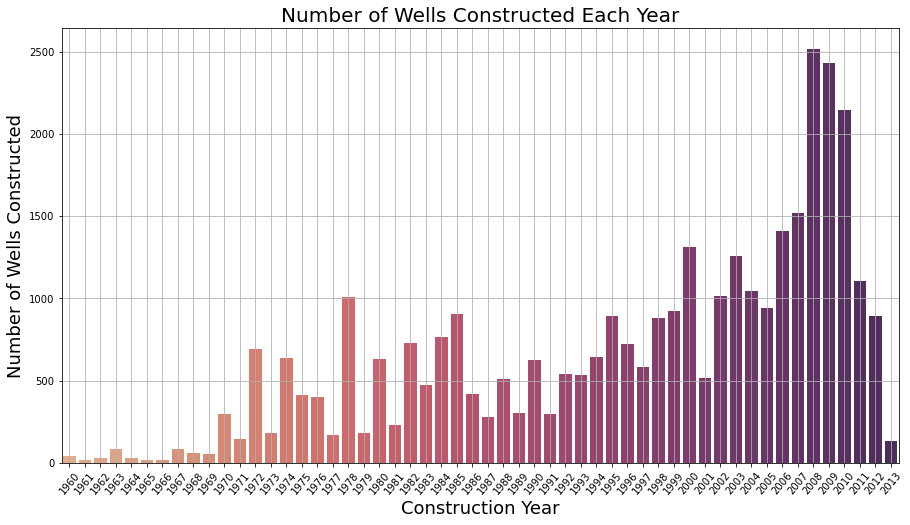

In [16]:
# group by year constucted
years = training_values.construction_year.value_counts().index[1:]
year_counts = training_values.construction_year.value_counts().values[1:]

# count the number of wells in each year
year_data = {
    'year': training_values.construction_year.value_counts().index[1:], 
    'count': training_values.construction_year.value_counts().values[1:]
}
year_df = pd.DataFrame(year_data)

plt.figure(figsize=(15,8))
sns.barplot(data=year_df, x='year', y='count', palette='flare')
plt.xticks(rotation=50)
plt.xlabel('Construction Year', fontsize=18)
plt.ylabel('Number of Wells Constructed', fontsize=18)
plt.title('Number of Wells Constructed Each Year', fontsize=20)
plt.grid()

### Locations of wells across Tanzania
- map generated using Tableau using well coordinates and inserted into this notbook
    - blue: functional
    - orange: functional, needs repair
    - red: non functional

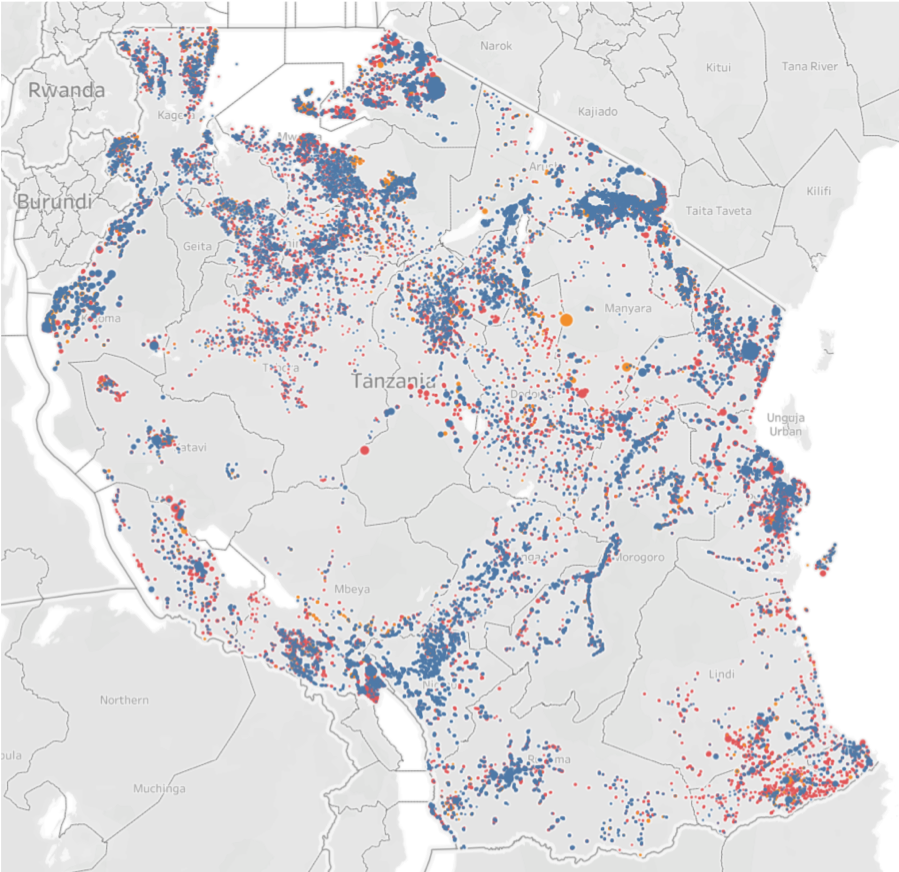

# Data Prep
Prepare the data to be compatible with classification

## Split the given training set into a train set and a test set

In [17]:
# create X and y variables
X = training_values.drop(columns=['id'], axis=1)
y = training_labels['status_group']

In [18]:
# pick a random seed to standardize the random selection
SEED = 5

In [19]:
# Split X and y into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

## Encode categorical data as binary values

In [20]:
# identify the non categorical columns that will not be included in the one hot encoding
non_categorical_cols = ['amount_tsh', 'gps_height', 'population', 'construction_year', 'num_private', 'region_code', 'latitude', 'longitude']

In [21]:
# initialize the One Hot Encoder
ohe = OneHotEncoder()

In [22]:
# create a function to perform the one hot encoding of the X data
def encode_X(X, non_categorical_cols):
    """
    function to encode a given X data set
        Inputs: 
            - X: dataframe to encode
            - non_categorical_cols: list of column names to exclude from encoding
        Outputs:
            - X_ohe_final: final encoded dataframe containing both encoded categorical data and non-categorical data
    """
    
    # create two dataframes: categorical and non categorical
    categorical_df = X.drop(columns=non_categorical_cols, axis=1)
    non_categorical_df = X[non_categorical_cols]

    # encode the categorical dataframe and convert back to a dataframe
    X_ohe_categorical = ohe.fit_transform(categorical_df).toarray()
    ohe_df = pd.DataFrame(X_ohe_categorical, columns=ohe.get_feature_names(categorical_df.columns))

    # combine the encoded categorical dataframe and the non categorical dataframe - DO I NEED THIS
    X_ohe = pd.concat([ohe_df, non_categorical_df], axis=1)

    # reset the index
    ohe_df['ind'] = categorical_df.index
    ohe_df = ohe_df.set_index('ind')
    ohe_df.head()

    # combine the encoded categorical dataframe and the non categorical dataframe
    X_ohe_final = pd.concat([ohe_df, non_categorical_df], axis=1)
    
    # check the number of columns in train and test sets to ensure they are the same
    print(len(X_ohe_final.columns))
    
    return X_ohe_final

In [23]:
# encode the train and test data sets
X_train_ohe = encode_X(X_train, non_categorical_cols)
X_test_ohe = encode_X(X_test, non_categorical_cols)

927
927


# Functions for Evaluating Model Performance

Model evaluation will occur several times throughout this notebook. These functions allow the model perfromance evaluation to be standareized easily applied for each model iteration 

4 functions are defined:
- create_y_ohe: encodes the data labels to allow metrics to be calculated for each label (there are 3 labels)
- performance_metrics: calcualtes performance metrics between a data set of test data labels and their predicted values
- evaluate_sbuset_performance: evaluates the performance of each subset of labels
- evaluate_model_performance: evaluate the performance of a model

In [24]:
# function to perform one hot encoding on the y results
def create_y_ohe(y, columns):
    """
    function to encode a given y data set
        Inputs: 
            - y: dataframe to encode
            - columns: list of column names included in the encoding
        Outputs:
            - y_ohe_df: final encoded dataframe
    """
    # initialize the encoder
    ohe = OneHotEncoder()
    
    # create a y dataframe
    y_df = pd.DataFrame(y, columns=columns)
    
    # encode the dataframe
    y_ohe = ohe.fit_transform(y_df).toarray()
    
    # converte the encoded y back into a dataframe 
    y_ohe_df = pd.DataFrame(y_ohe, columns=ohe.get_feature_names(y_df.columns))
    
    return y_ohe_df

    
# functional subset accuracy
def performance_metrics(y_test, y_pred):
    """
    function to calcualte performance metrics between a data set of test data labels and their predicted values
        Inputs: 
            - y_test: known labels for the test data set
            - y_pred: predicted labels for the test data set
        Outputs:
            - results: dictionary containing performance metircs including:
                - accuracy, precision, recall, mean-squared_error, f1, and auc
    """
    
    # calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # organize metrics into a dictionary
    results = {
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall ,4),
        'mse': round(mse, 4),
        'f1': round(f1, 4),
        'auc': round(roc_auc, 4)
    }
    
    return results


def evaluate_sbuset_performance(y_test_ohe_df, y_pred_ohe_df):
    """
    function to evaluate the performance of each subset of labels 
        Inputs: 
            - y_test_ohe_df: encoded dataframe of known labels for the test data set
            - y_pred_ohe_dt: encoded dataframe of predicted labels for the test data set
        Outputs:
            - subset_results: dictionary containing performance metircs for each subset
                - each set of results within a key named for the subset
                    'subset': {
                        accuracy: val,
                        precision: val,
                        recall: val,
                        mse: val,
                        auc: val
                    }            
    """
    # define the subsets withing the labels
    subsets = ['status_group_functional', 'status_group_functional needs repair', 'status_group_non functional']
    
    subset_results = {}
    
    # loop through each subset label and create 
    for subset in subsets:
        
        # if one subset is not present in the predicted labels given, create a column of 0's for it
        try:
            y_pred = y_pred_ohe_df[subset]
        except KeyError:
            y_pred_ohe_df[subset] = np.zeros(len(y_pred_ohe_df))
        
        y_test = y_test_ohe_df[subset]
        
        # calculate the subset results
        subset_results[subset] = performance_metrics(y_test, y_pred)
    
    return subset_results
        

def evaluate_model_performance(y_test, y_pred):
    """
    function to evaluate the performance of a model
        Inputs: 
            - y_test: array of known labels for the test data set
            - y_pred: array of predicted labels for the test data set
        Outputs:
            - results: dictionary containing performance metircs for each subset and the average metrics
                - each set of results within a key named for the subset
                    'subset': {
                        accuracy: val,
                        precision: val,
                        recall: val,
                        mse: val,
                        auc: val
                    }            
    """
    # convert the label arrays into encoded dataframes in order to calculate the metrics for each label
    y_test_ohe_df = create_y_ohe(y_test, columns=['status_group'])
    y_pred_ohe_df = create_y_ohe(y_pred, columns=['status_group'])
    
    # calculate the performance for each label subset
    subset_results = evaluate_sbuset_performance(y_test_ohe_df, y_pred_ohe_df)
    
    # average the subset results together to get an evaluation for the whole model
    accuracy = []
    precision = []
    recall = []
    mse = []
    f1 = []
    auc = []
    for subset in subset_results.keys():
        
        accuracy.append(subset_results[subset]['accuracy'])
        precision.append(subset_results[subset]['precision'])
        recall.append(subset_results[subset]['recall'])
        mse.append(subset_results[subset]['mse'])
        f1.append(subset_results[subset]['f1'])
        auc.append(subset_results[subset]['auc'])
    
    avg_accuracy = round(np.array(accuracy).mean(), 4)
    avg_precision = round(np.array(precision).mean(), 4)
    avg_recall = round(np.array(recall).mean(), 4)
    avg_mse = round(np.array(mse).mean(), 4)
    avg_f1 = round(np.array(f1).mean(), 4)
    avg_auc = round(np.array(auc).mean(), 4)
    
    results = {
        'accuracy': avg_accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'auc': avg_auc,
        'mse': avg_mse,
        'f1': avg_f1,
        'subsets': subset_results
    }
    
    return results

# Base Model

## Train the tree

- the criterion "gini" was chosen, as it is typically faster than "entropy"
- the same random state is used in the decision tree as the train/test split

In [25]:
criterion='gini'

# intialize and fit the tree
clf_base = DecisionTreeClassifier(criterion=criterion, random_state=SEED)
clf_base.fit(X_train_ohe, y_train)

DecisionTreeClassifier(random_state=5)

## Use the tree to predict labels for the test data set

In [26]:
y_pred_base = clf_base.predict(X_test_ohe)

In [27]:
X_test_ohe.head()

,funder_0,funder_Aar,funder_Abasia,funder_Acra,funder_Adb,funder_Adp,funder_Adra,funder_African,funder_African Development Bank,funder_Aict,...,waterpoint_type_group_improved spring,waterpoint_type_group_other,amount_tsh,gps_height,population,construction_year,num_private,region_code,latitude,longitude
55949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1748,1200,1973,0,21,-4.275765,35.261526
952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.0,50,400,1985,5,4,-5.349193,38.975596
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1369,500,2006,0,17,-2.977249,34.275928
6574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,19,-2.697696,32.571072
38849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3000.0,1931,1,1982,0,15,-8.013818,31.671361


## Evaluate the base model performance

Which value will be our primary metric?
- the goal of this model is to identify which water wells are not functioning as intended, and therefore need to be repaired or fixed.
- We want to avoid identifying a well as functioning when it is not functioning (false positives)
    - We would rather visit a well that is working rather than not visit a well that isn't, assuming we have the man power available
- Therefore, the metric we will be prioritizing is precision, as it prioritizes minimizing false positives rather than false negatives

In [28]:
results = evaluate_model_performance(y_test.values, y_pred_base)

print(f'Model 1 Performance - Average')
print(f'  accuracy = {results["accuracy"]}')
print(f' ** precision = {results["precision"]} **')
print(f'  recall = {results["recall"]}')
print(f'  auc = {results["auc"]}')

print(f'Model 1 Performance - Functional')
print(f'  accuracy = {results["subsets"]["status_group_functional"]["accuracy"]}')
print(f' ** precision = {results["subsets"]["status_group_functional"]["precision"]} **')
print(f'  recall = {results["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {results["subsets"]["status_group_functional"]["auc"]}')

Model 1 Performance - Average
  accuracy = 0.8388
 ** precision = 0.6538 **
  recall = 0.649
  auc = 0.7523
Model 1 Performance - Functional
  accuracy = 0.7831
 ** precision = 0.8025 **
  recall = 0.8028
  auc = 0.781


We have an precision of 80% with no model tailoring

# Hyperparemeter Tuning
Tune the model by determining the optimal value for 4 model parameters:
- max_features
- min_samples_split
- min_samples_leaf
- max_features

### Function to perform the tuning

Grid search major - use precision as the metric to define what the best model
4 nested for loops - maybe try another algorigthms - use random forest, XG Boost

Include a classification report (call to scikit learn) - compare to my function
- get a confustion matrix in there (communicate false positives)

Feature Importance: 
- at the end of the analysis, calculate feature importance of the best performing model (decision tree vs forest, etc)
- areas for the NGO to focus on to repair and help with longevity
- kinda like analyzing coefficients in linear regression

3 recs:
- model, then 2 most important features

### Function to perform the tuning
Define a function to investigate a range of values for a given parameter on the effect they have on the model. 
- This function will be used to perform tuning on the base model and determine the best values for each parameter

In [29]:
def investigate_parameter(param_name, param_values, 
                          max_depth=None, min_samples_leaf=1, min_samples_split=2, max_features=None):
    """
    function to investigate a range of values for a given parameter on the effect they have on the model 
    
        Inputs: 
            - param_name: name of the parameter associated with the range of values give
            - param_values: range of values to test
            - max_depth: option to set a specific value for the max depth (defaults to standard default, None)
            - max_samples_leaf: option to set a specific value for the max samples leaf (defaults to standard default, 1)
            - min_samples_split: option to set a specific value for the max samples split (defaults to standard default, 2)
            - max_features: option to set a specific value for the max features (defaults to standard default, None)
    """
    # initialize metric storage
    train_auc = []
    test_auc = []
    
    train_accuracy = []
    test_accuracy = []
    
    train_precision = []
    test_precision = []
    
    train_recall = []
    test_recall = []

    # loop through each value and calculate the performance metrics for the resulting decisoin tree
    for value in param_values:
        
#         print(value)
        
        # select the decision tree that uses the range of values specified
        if param_name == 'max_depth': 
            dt = DecisionTreeClassifier(criterion=criterion, 
                                        max_depth=value,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        max_features=max_features,
                                        random_state=SEED)
        elif param_name == 'min_samples_leaf':
            dt = DecisionTreeClassifier(criterion=criterion,  
                                        max_depth=max_depth,
                                        min_samples_leaf=value,
                                        min_samples_split=min_samples_split,
                                        max_features=max_features,
                                        random_state=SEED)
        elif param_name == 'min_samples_split':
            dt = DecisionTreeClassifier(criterion=criterion, 
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=value,
                                        max_features=max_features,
                                        random_state=SEED)
        elif param_name == 'max_features':
            dt = DecisionTreeClassifier(criterion=criterion, 
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        max_features=value, 
                                        random_state=SEED)
        # fit the tree
        dt.fit(X_train_ohe, y_train)

        # predict the train and test labels
        train_pred = dt.predict(X_train_ohe)
        test_pred = dt.predict(X_test_ohe)

        # evaluate model performance for both the train and test data sets
        test_performance = evaluate_model_performance(y_test, test_pred)
        train_performance = evaluate_model_performance(y_train, train_pred)

        # accumulate metrics for each parameter value to plot
        train_auc.append(train_performance["subsets"]["status_group_functional"]['auc'])
        test_auc.append(test_performance["subsets"]["status_group_functional"]['auc'])
        
        train_precision.append(train_performance["subsets"]["status_group_functional"]['precision'])
        test_precision.append(test_performance["subsets"]["status_group_functional"]['precision'])
        
        train_recall.append(train_performance["subsets"]["status_group_functional"]['recall'])
        test_recall.append(test_performance["subsets"]["status_group_functional"]['recall'])
        
        train_accuracy.append(train_performance["subsets"]["status_group_functional"]['accuracy'])
        test_accuracy.append(test_performance["subsets"]["status_group_functional"]['accuracy'])

    # determine the parameter value with the hightest precision on the test set
    max_precision = max(test_precision)
    max_value = param_values[test_precision.index(max_precision)]
    
    # plot the auc value for train and test results
    plt.figure(figsize=(15, 8))
    plt.plot(param_values, train_auc, label='train auc')
    plt.plot(param_values, test_auc, label='test auc')
    plt.grid()
    plt.xlabel(param_name)
    plt.ylabel('auc')
    plt.legend()
    plt.show()
    
    # plot the precision, recall, and accuracy for the test results
    plt.figure(figsize=(15, 8))
    plt.plot(param_values, test_precision, label='test precision')
    plt.plot(param_values, test_recall, label='test recall')
    plt.plot(param_values, test_accuracy, label='test accuracy')
    plt.grid()
    plt.xlabel(param_name)
    plt.ylabel('auc')
    plt.legend()
    plt.show()
    
    return max_value, max_precision
    
#     plt.figure(figsize=(15, 8))
#     plt.plot(param_values, test_precision, label='test precision')
#     plt.grid()
#     plt.xlabel(param_name, fontsize=16)
#     plt.ylabel('Precision', fontsize=16)
#     plt.title('Test Precision for a Range of Max Depths', fontsize=20)
#     plt.legend()
#     plt.show()
    

# Investigate parameters 
Investigate ranges for each parameter. 
- select the value that returns the highest precision
- select a range of values including that value to be used in a grid search

## Max Depth

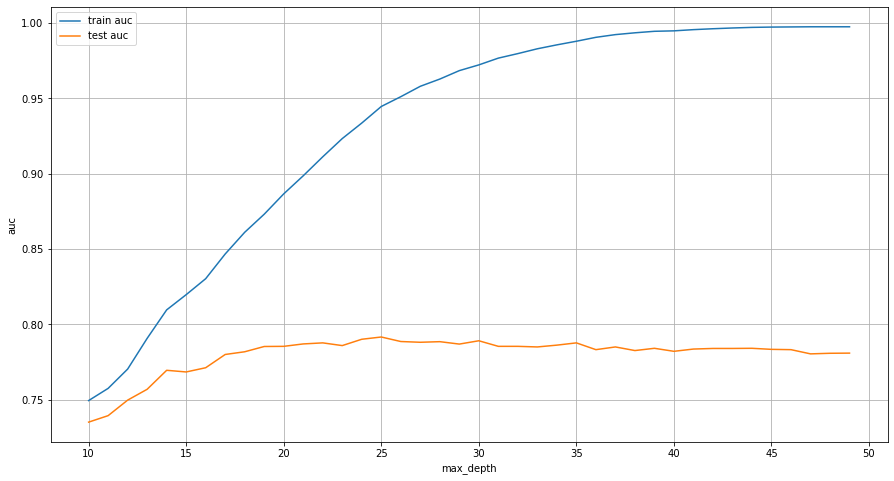

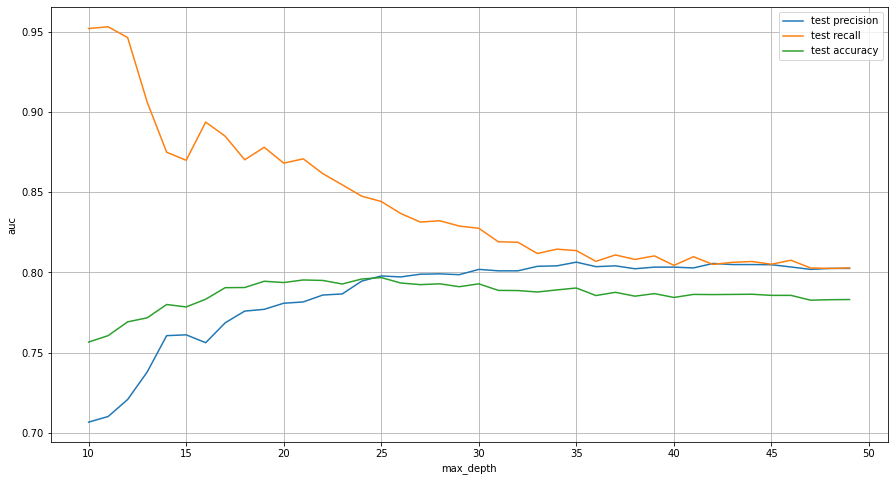

In [30]:
# initialize a list of parameters and submit to the investigate parameters function
max_depths = list(range(10,50))
max_depth, max_precision = investigate_parameter(param_name='max_depth', param_values=max_depths)    

### Results

In [31]:
# select the max depth value with the highest precision
selected_max_depth = max_depth

# define a range of max depth values to in put in the grid search via inspection
selected_max_depth_range = list(range(30, 46))
selected_max_depth_range.extend([None])  # include the default value in the range of test values

In [32]:
# create, fit, and predict the model iteration for this parameter tuning
clf2 = DecisionTreeClassifier(criterion=criterion, 
                             max_depth=selected_max_depth,
                             random_state=SEED)
clf2.fit(X_train_ohe, y_train)
y_pred_2 = clf2.predict(X_test_ohe)

In [33]:
# evaluate the new model and print key metrics
results2 = evaluate_model_performance(y_test.values, y_pred_2)

print(f'Model 2 Performance - Average')
print(f'  accuracy = {results2["accuracy"]}')
print(f'  precision = {results2["precision"]}')
print(f'  recall = {results2["recall"]}')
print(f'  auc = {results2["auc"]}')

print(f'Model 2 Performance - Functional')
print(f'  accuracy = {results2["subsets"]["status_group_functional"]["accuracy"]}')
print(f'  precision = {results2["subsets"]["status_group_functional"]["precision"]}')
print(f'  recall = {results2["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {results2["subsets"]["status_group_functional"]["auc"]}')

Model 2 Performance - Average
  accuracy = 0.8432
  precision = 0.6611
  recall = 0.6543
  auc = 0.7567
Model 2 Performance - Functional
  accuracy = 0.7903
  precision = 0.8064
  recall = 0.8136
  auc = 0.7878


### Interpret Results

- precision increased as the max depth increased, until it plateaued around 30.
- the average and function precision values both increased
- the highest precision found with a max depth at 35 
- recall started high then fell as max depth increased until it plateaued around 30

## Min Samples Split

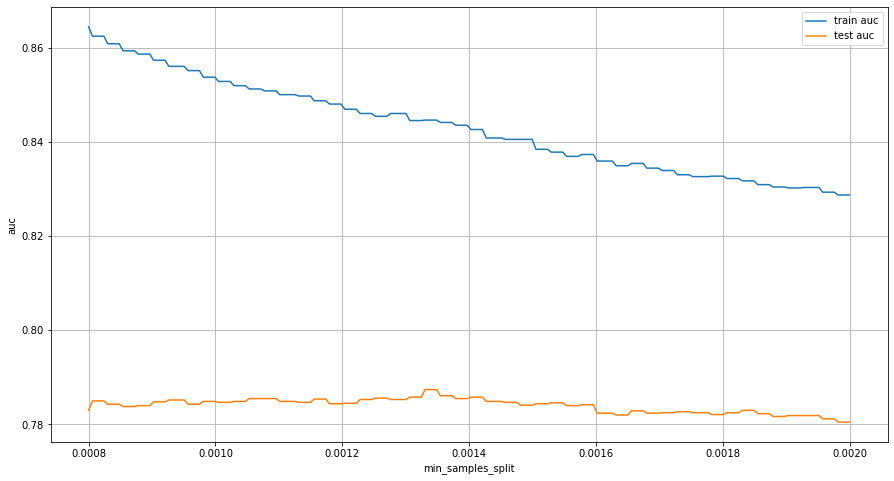

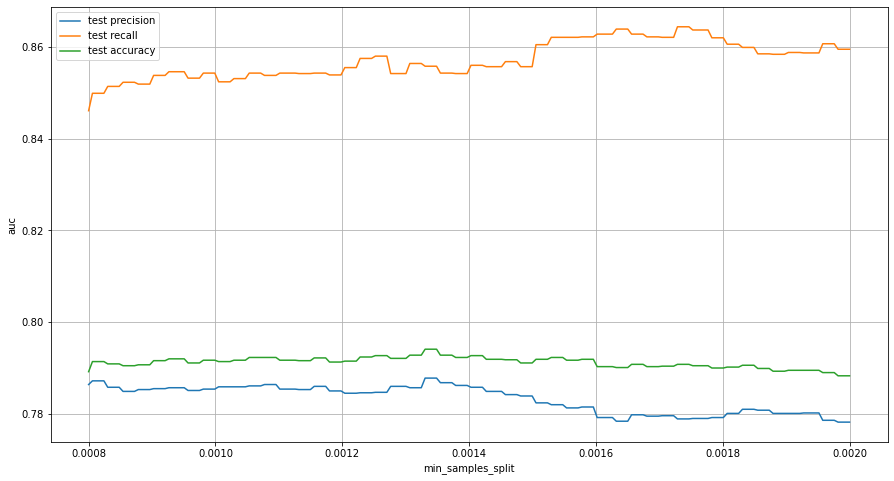

In [34]:
# initialize a list of parameters and submit to the investigate parameters function
min_samples_splits = np.linspace(0.0008, 0.002, 200, endpoint=True)
min_samples_split, max_precision_split = investigate_parameter(param_name='min_samples_split', param_values=min_samples_splits, max_depth=selected_max_depth)

### Results

In [35]:
# select the min samples split value with the highest precision
selected_min_samples_split = min_samples_split
print(selected_min_samples_split)
selected_min_samples_split_range = list(np.linspace(0.001, 0.002, 9, endpoint=True))
selected_min_samples_split_range.append(2)

0.0013306532663316583


In [36]:
# create, fit, and predict the model iteration for this parameter tuning
clf3 = DecisionTreeClassifier(criterion=criterion, 
                              max_depth=selected_max_depth,
                              min_samples_split=selected_min_samples_split,
                              random_state=SEED)
clf3.fit(X_train_ohe, y_train)
y_pred_3 = clf3.predict(X_test_ohe)

In [37]:
# evaluate the new model and print key metrics
results3 = evaluate_model_performance(y_test.values, y_pred_3)

print(f'Model 3 Performance - Average')
print(f'  accuracy = {results3["accuracy"]}')
print(f'  precision = {results3["precision"]}')
print(f'  recall = {results3["recall"]}')
print(f'  auc = {results3["auc"]}')

print(f'Model 3 Performance - Functional')
print(f'  accuracy = {results3["subsets"]["status_group_functional"]["accuracy"]}')
print(f'  precision = {results3["subsets"]["status_group_functional"]["precision"]}')
print(f'  recall = {results3["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {results3["subsets"]["status_group_functional"]["auc"]}')

Model 3 Performance - Average
  accuracy = 0.8482
  precision = 0.6889
  recall = 0.6249
  auc = 0.7403
Model 3 Performance - Functional
  accuracy = 0.7941
  precision = 0.7878
  recall = 0.8558
  auc = 0.7874


### Interpret Results
- there is not a reliable increase throughout the range of min samples split given
    - the optimal value results in an increase in average precision, but not functional precision
- seeing as there is no disntinct increase in precision, it is likely that the default value will be the most accurate, however, a range of values will still be submitted to the grid search to investigate how they are affected by the other parameters

## Min Samples Leaf

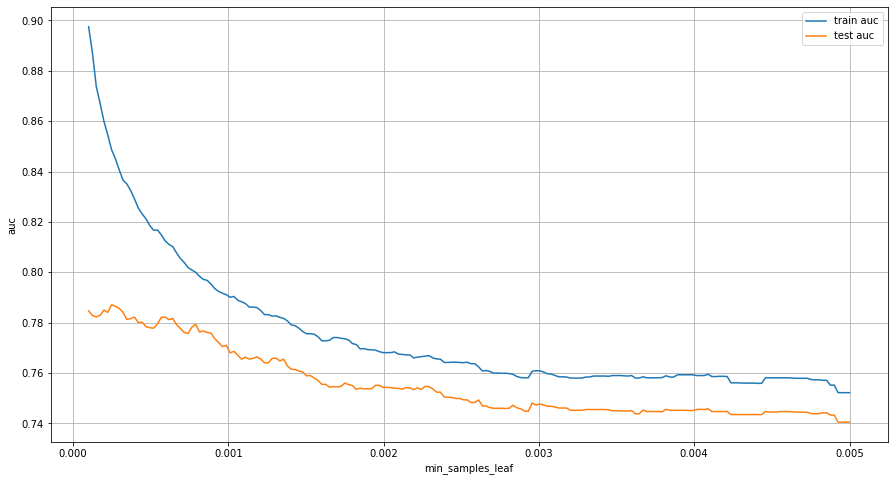

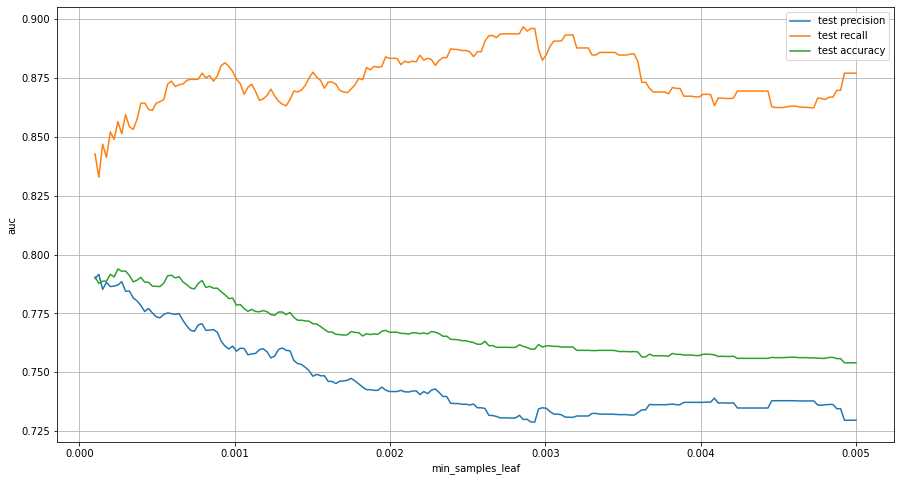

In [38]:
# initialize a list of parameters and submit to the investigate parameters function
min_samples_leafs = np.linspace(10e-5, 500e-5, 200, endpoint=True)
min_samples_leaf, max_precision_leaf = investigate_parameter(param_name='min_samples_leaf', 
                                                               param_values=min_samples_leafs, 
                                                               max_depth=selected_max_depth,
                                                               min_samples_split=2)  

### Results

In [39]:
# select the min samples leaf value with the highest precision
selected_min_samples_leaf = min_samples_leaf
selected_min_samples_leaf_range = list(np.linspace(19e-5, 28e-5, 10, endpoint=True))
selected_min_samples_leaf_range.append(1)

In [40]:
# create, fit, and predict the model iteration for this parameter tuning
clf4 = DecisionTreeClassifier(criterion=criterion, 
                              max_depth=selected_max_depth,
                              min_samples_split=selected_min_samples_split,
                              min_samples_leaf=selected_min_samples_leaf,
                              random_state=SEED)
clf4.fit(X_train_ohe, y_train)
y_pred_4 = clf4.predict(X_test_ohe)

In [41]:
# evaluate the new model and print key metrics
results4 = evaluate_model_performance(y_test.values, y_pred_4)

print(f'Model 4 Performance - Average')
print(f'  accuracy = {results4["accuracy"]}')
print(f'  precision = {results4["precision"]}')
print(f'  recall = {results4["recall"]}')
print(f'  auc = {results4["auc"]}')

print(f'Model 4 Performance - Functional')
print(f'  accuracy = {results4["subsets"]["status_group_functional"]["accuracy"]}')
print(f'  precision = {results4["subsets"]["status_group_functional"]["precision"]}')
print(f'  recall = {results4["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {results4["subsets"]["status_group_functional"]["auc"]}')

Model 4 Performance - Average
  accuracy = 0.8488
  precision = 0.6941
  recall = 0.6182
  auc = 0.7364
Model 4 Performance - Functional
  accuracy = 0.7938
  precision = 0.7832
  recall = 0.8636
  auc = 0.7861


### Interpretation
- there is a decrease in precision as min_samples_leaf increases, indicating that smaller values will return higher precision
- with the optimal value selected, average precision increased, while functional precision decreased

## Max Features

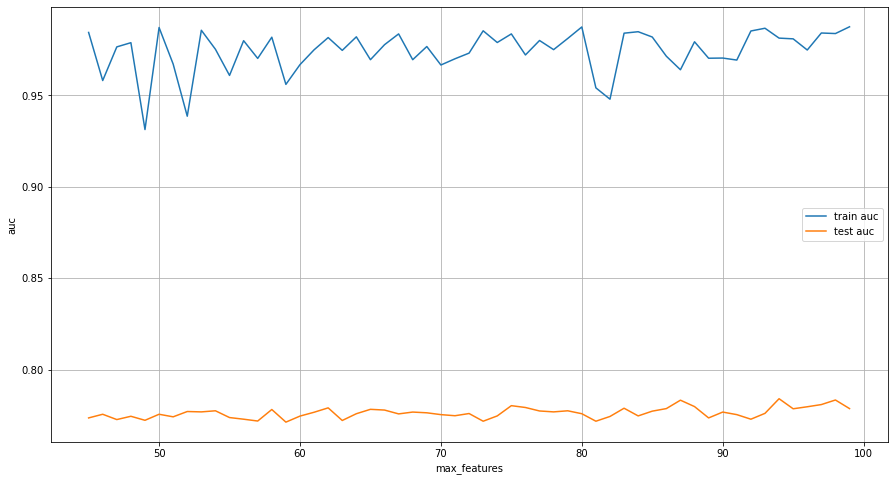

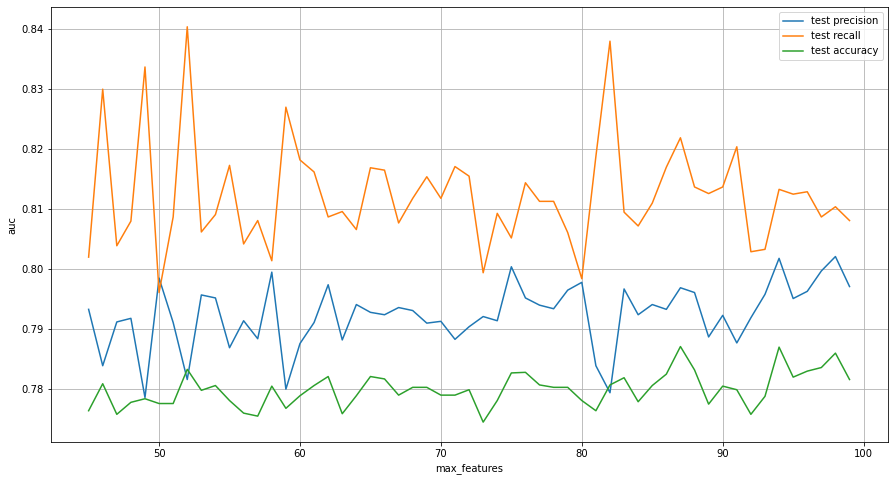

In [42]:
# initialize a list of parameters and submit to the investigate parameters function
max_features = list(range(45, 100))
max_feature, max_precision_features = investigate_parameter(param_name='max_features', param_values=max_features, 
                                                             max_depth=selected_max_depth)  

### Results

In [173]:
# select the max features value with the highest precision
selected_max_features = max_feature
selected_max_features_range = list(range(73, 100))
selected_max_features_range.extend([None])

In [176]:
print(max_feature)

98


In [177]:
# create, fit, and predict the model iteration for this parameter tuning
clf5 = DecisionTreeClassifier(criterion=criterion, 
                              max_depth=selected_max_depth,
                              max_features=selected_max_features, 
                              random_state=SEED)
clf5.fit(X_train_ohe, y_train)
y_pred_5 = clf5.predict(X_test_ohe)

In [178]:
# evaluate the new model and print key metrics
results5 = evaluate_model_performance(y_test.values, y_pred_5)

print(f'Model 5 Performance - Average')
print(f'  accuracy = {results5["accuracy"]}')
print(f'  precision = {results5["precision"]}')
print(f'  recall = {results5["recall"]}')
print(f'  auc = {results5["auc"]}')

print(f'Model 5 Performance - Functional')
print(f'  accuracy = {results5["subsets"]["status_group_functional"]["accuracy"]}')
print(f'  precision = {results5["subsets"]["status_group_functional"]["precision"]}')
print(f'  recall = {results5["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {results5["subsets"]["status_group_functional"]["auc"]}')

Model 5 Performance - Average
  accuracy = 0.8401
  precision = 0.6506
  recall = 0.6475
  auc = 0.7522
Model 5 Performance - Functional
  accuracy = 0.786
  precision = 0.8021
  recall = 0.8104
  auc = 0.7834


### Interpret Results
- there is a large difference between precision as max features increase without a clear trend. 
- the optimal value selection seems more random rather than a distinct peak. 

# Grid Search
Using the ranges of values selected in the inital parameter tuning iterations, iterate through all possible combinations in a search for the combination of paramters that results in the highest functional precision.


In [113]:
# initialize storage
params_grid = []
functional_binary_precision_grid = []
non_functional_binary_precision_grid = []
average_precision_grid = []
performance_grid = []

# create 4 nested for loops that create a grid search that iterates between all possible parameter combinations
def grid_search(max_depths, min_samples_splits, min_samples_leafs, max_features):
    for max_depth in max_depths:
        print(max_depth)  # print current max depth to keep track of progress
        
        for min_samples_split in min_samples_splits:
            print(f'    {min_samples_split}')  # print current min samples split to keep track of progress
            
            for min_samples_leaf in min_samples_leafs:
                
                for max_feature in max_features:
                    
                    # define a decision tree with the current combination of paramters
                    dt = DecisionTreeClassifier(criterion=criterion, 
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        min_samples_split=min_samples_split,
                                        max_features=max_feature,
                                        random_state=SEED)
                    # fit the tree
                    dt.fit(X_train_ohe, y_train)

                    # predict test results
                    test_pred = dt.predict(X_test_ohe)
                    # train_pred = dt.predict(X_train_ohe)

                    # evaluate test performance
                    test_performance = evaluate_model_performance(y_test.values, test_pred)
                    # train_performance = evaluate_model_performance(y_train, train_pred)
                    
                    # accumulate performance results
                    performance_grid.append(test_performance)

                    functional_binary_precision = test_performance['subsets']['status_group_functional']['precision']
                    functional_binary_precision_grid.append(functional_binary_precision)
        
                    non_functional_binary_precision = test_performance['subsets']['status_group_non functional']['precision']
                    non_functional_binary_precision_grid.append(non_functional_binary_precision)
    
                    average_precision = test_performance['precision']
                    average_precision_grid.append(average_precision)
        
                    params = [max_depth, min_samples_split, min_samples_leaf, max_feature]
                    params_grid.append(params)
                
    # find the parameters that result in the hightest average precision
    max_avg_precision = max(average_precision_grid)
    max_avg_precision_params = params_grid[average_precision_grid.index(max_avg_precision)]
    
    # find the parameters that result in the highest functional precision
    max_functional_binary_precision = max(functional_binary_precision_grid)
    max_functional_binary_precision_params = params_grid[functional_binary_precision_grid.index(max_functional_binary_precision)]
    
    # find the parameters that result in the highest non-functional precision
    max_non_functional_binary_precision = max(non_functional_binary_precision_grid)
    max_non_functional_binary_precision_params = params_grid[non_functional_binary_precision_grid.index(max_non_functional_binary_precision)]
    
    print(f'avg precision: {round(max_avg_precision*100, 2)}%: params = {max_avg_precision_params}')
    print(f'functional precision: {round(max_functional_binary_precision*100, 2)}%: params = {max_functional_binary_precision_params}')
    print(f'non functional precision: {round(max_non_functional_binary_precision*100, 2)}%: params = {max_non_functional_binary_precision_params}')

    results = {
        'max_avg_precision': max_avg_precision,
        'max_avg_precision_params': max_avg_precision_params,
        'max_functional_binary_precision': max_functional_binary_precision,
        'max_functional_binary_precision_params': max_functional_binary_precision_params,
        'max_non_functional_binary_precision': max_non_functional_binary_precision,
        'max_non_functional_binary_precision_params': max_non_functional_binary_precision_params,
        'performance_grid': performance_grid,
        'parameters_grid': params_grid
    }
    
    return results
    
grid_results = grid_search(selected_max_depth_range, selected_min_samples_split_range, selected_min_samples_leaf_range, selected_max_features_range)

import json
with open("data/grid_results.json", "w") as f:
    json.dump(grid_results, f)

30
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
31
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
32
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
33
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
34
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
35
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
36
    0.001
    0.0011250000000000001
    0.00125
    0.001375
    0.0015
    0.0016250000000000001
    0.00175
    0.001875
    0.002
    2
37
   

### Interpret Results
- prior to hyperparameter tuning, the model functional precision was 80.25%. 
- after hyperparameter tuning, the model functional precision is 80.69%
- there is an increase in functional precision of 0.44%

# Final Model - Decision Tree
Run the final model chosen to maximize functional precision

In [179]:
# select the final model parameters
chosen_final_model_params = max_functional_binary_precision_params

final_max_depth = chosen_final_model_params[0]
final_min_samples_split = chosen_final_model_params[1]
final_min_samples_leaf = chosen_final_model_params[2]
final_max_features = chosen_final_model_params[3]

In [180]:
# define and train a the decision tree, and predict the test labels
clf_final = DecisionTreeClassifier(criterion=criterion, 
                                   max_depth=final_max_depth,
                                   min_samples_split=final_min_samples_split,
                                   min_samples_leaf=final_min_samples_leaf,
                                   max_features=final_max_features, 
                                   random_state=SEED)
clf_final.fit(X_train_ohe, y_train)
y_pred_final = clf_final.predict(X_test_ohe)

In [181]:
final_results = evaluate_model_performance(y_test.values, y_pred_final)

print(f'Final Model Performance - Average')
print(f'  accuracy = {final_results["accuracy"]}')
print(f'  precision = {final_results["precision"]}')
print(f'  recall = {final_results["recall"]}')
print(f'  auc = {final_results["auc"]}')

print(f'Final Model Performance - Functional')
print(f'  accuracy = {final_results["subsets"]["status_group_functional"]["accuracy"]}')
print(f'  precision = {final_results["subsets"]["status_group_functional"]["precision"]}')
print(f'  recall = {final_results["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {final_results["subsets"]["status_group_functional"]["auc"]}')

Final Model Performance - Average
  accuracy = 0.8422
  precision = 0.6524
  recall = 0.6493
  auc = 0.7542
Final Model Performance - Functional
  accuracy = 0.789
  precision = 0.8069
  recall = 0.8098
  auc = 0.7868


# Random Forest Using Final Decision Tree Parameters
Input the final decision tree parameters into a random forest.

In [117]:
# define random forest parameters
n_estimators=100
n_jobs=None

# define the random forest and train it
forest = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                               max_depth=final_max_depth, max_features=final_max_features,
                               min_samples_split=final_min_samples_split, min_samples_leaf=final_min_samples_leaf,
                               n_jobs=n_jobs, random_state=SEED)
forest.fit(X_train_ohe, y_train)

# use the forest to predict the test labels
y_forest = forest.predict(X_test_ohe)

In [118]:
forest_results = evaluate_model_performance(y_test.values, y_forest)

print(f'Final Model Performance - Average')
print(f'  accuracy = {forest_results["accuracy"]}')
print(f'  precision = {forest_results["precision"]}')
print(f'  recall = {forest_results["recall"]}')
print(f'  auc = {forest_results["auc"]}')

print(f'Final Model Performance - Functional')
print(f'  accuracy = {forest_results["subsets"]["status_group_functional"]["accuracy"]}')
print(f'  precision = {forest_results["subsets"]["status_group_functional"]["precision"]}')
print(f'  recall = {forest_results["subsets"]["status_group_functional"]["recall"]}')
print(f'  auc = {forest_results["subsets"]["status_group_functional"]["auc"]}')

Final Model Performance - Average
  accuracy = 0.8683
  precision = 0.7136
  recall = 0.6647
  auc = 0.7699
Final Model Performance - Functional
  accuracy = 0.82
  precision = 0.8086
  recall = 0.8807
  auc = 0.8133


### Interpretaion
- after hyperparameter tuning, the model functional precision is 80.69%
- using the same optimized hyperparameters, the model functional precision is increased to 80.86%
- there is an increase in functional precision of 0.61% from the orignal base model

# Confusion Matrix
Generate a confusion matrix to illustrate the numbers of true postives, true negaties, false positives, and fasle negatives

## Final Model

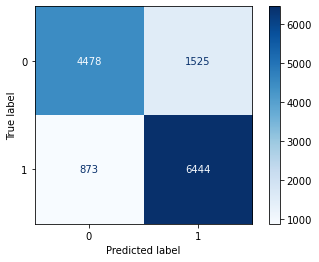

In [131]:
y_test_ohe_df = create_y_ohe(y_test, columns=['status_group'])
y_pred_ohe_df = create_y_ohe(y_forest, columns=['status_group'])

y_test_functional = y_test_ohe_df['status_group_functional'].values
y_pred_functional = y_pred_ohe_df['status_group_functional'].values

cfm = confusion_matrix(y_test_functional, y_pred_functional)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Base Model

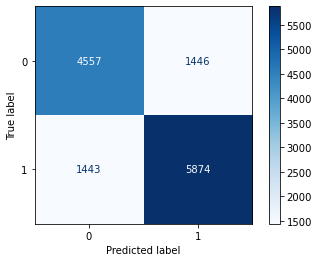

In [182]:
y_test_ohe_df = create_y_ohe(y_test, columns=['status_group'])
y_pred_ohe_df = create_y_ohe(y_pred_base, columns=['status_group'])

y_test_functional = y_test_ohe_df['status_group_functional'].values
y_pred_functional = y_pred_ohe_df['status_group_functional'].values

cfm = confusion_matrix(y_test_functional, y_pred_functional)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Interpretation
Our goal was to minimize the number of false positives by using precision as out primary metric. 

# Random Forest Feature Importance
Investigate the features to determine the which characteristics of the pumps have the largest effect on their functionality.

In [119]:
# define the importances and their standard deivations
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [148]:
# define feature names, importances, and their standard deviations
feature_names = np.array(X_train_ohe.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# create a data frame for all the importances
data={
    'feature': feature_names,
    'importance': importances,
    'std': std
}
forest_importances = pd.DataFrame(data)

# filter the importances to only include the top features, then sort
forest_importances_filtered = forest_importances[forest_importances['importance'] > 0.015]
forest_importances_filtered = forest_importances_filtered.set_index('feature')
forest_importances_filtered = forest_importances_filtered.sort_values(by='importance')

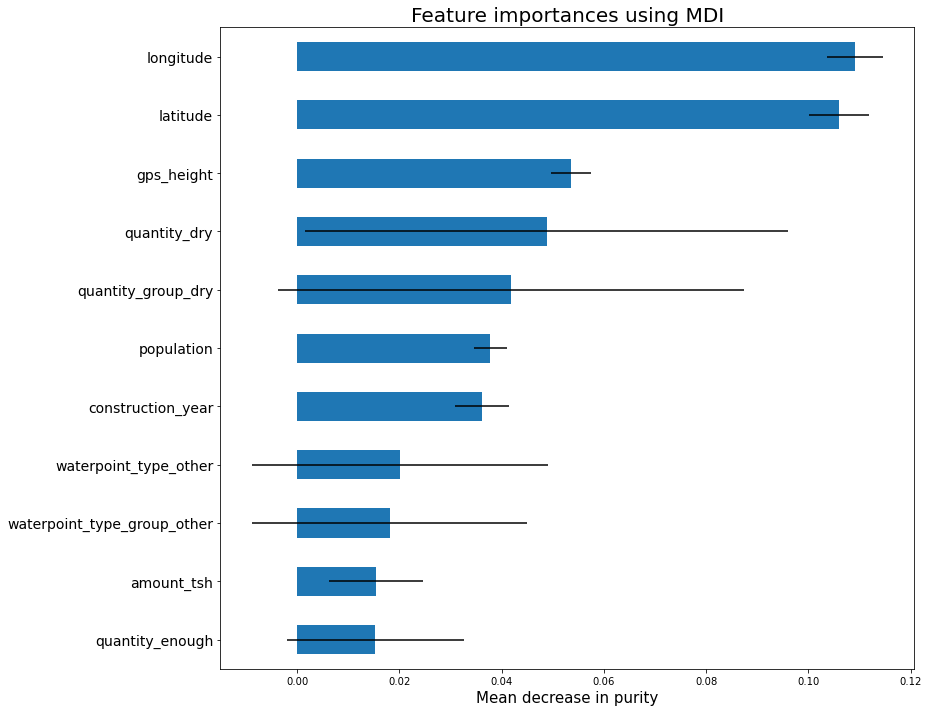

In [150]:
# plot feature importances
fig, ax = plt.subplots(figsize=(13,10))
forest_importances_filtered['importance'].plot.barh(xerr=forest_importances_filtered['std'], ax=ax)
ax.set_title("Feature importances using MDI", fontsize=20)
ax.set_xlabel("Mean decrease in purity", fontsize=15)
ax.set_ylabel('', )
plt.yticks(fontsize=14)
fig.tight_layout()

### Interpretaion

The top features that are most important in determining if a water pump is functional:
1. location (latitude/longitude)
2. elevation (gps_height)
3. water quantity